# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

100%|██████████| 306M/306M [00:30<00:00, 10.5MB/s] 

Extracting files...


Path to dataset files: /home/prometheus/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


a
xqCLaIfsVBFNf63M.png


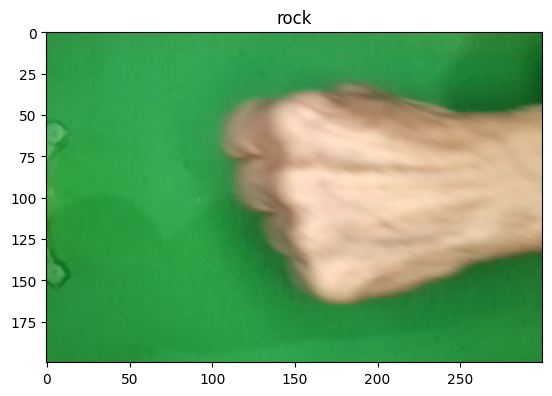

In [13]:
plt.figure()
print(random.choice(['a','b','c']))
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
print(img_name)
plt.imshow(io.imread(os.path.join(folder,img_name)))
plt.title('rock')
plt.show()

# Dataset creation

In [ ]:
class RPSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_wdir = root_dir
        self.transform = transform
    def __len__(self):
        return 100
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_class = 
        img = io.imread()
